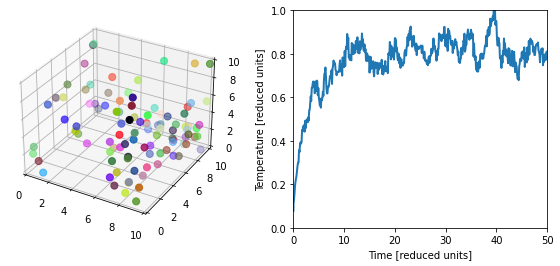

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

N = 100  # number of particles
L = np.array([10, 10, 10])  # simulation box size (reduced units)
r_min = 0.9  # minimum separation (reduced units)
h = 1e-3  # time step size (reduced units)
t_end = 50  # total simulation time (reduced units)

duration = 10  # video duration in secs
fps = 50  # frames per second

frames = duration * fps  # number of frames
stepsPerFrame = round(t_end / h / frames)  # timesteps per animation frame

# initialize the particles
x = np.zeros((3, N))  # position
v = np.zeros((3, N))  # velocity
a = np.zeros((3, N))  # acceleration
i = 0
while i < N:
    x[:, i] = np.random.rand(3) * L
    for j in range(i):
        dx = x[:, j] - x[:, i]
        dx = dx - np.round(dx / L) * L
        if np.dot(dx, dx) < r_min**2:
            i -= 1  # particles too close, draw a new random position for it
            break
    i += 1

# figure preparation
fig = plt.figure(figsize=(10, 4))
ax3 = fig.add_subplot(1, 2, 1, projection='3d')
p3 = ax3.scatter(x[0, :], x[1, :], x[2, :], c=np.random.rand(N, 3), s=50)
ax3.grid(True)
ax3.set_xlim(0, L[0])
ax3.set_ylim(0, L[1])
ax3.set_zlim(0, L[2])
ax2 = fig.add_subplot(1, 2, 2)
line, = ax2.plot([], [], lw=2)
ax2.set_xlim(0, t_end)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Time [reduced units]')
ax2.set_ylabel('Temperature [reduced units]')


def update(frame):
    global x, v, a
    for s in range(stepsPerFrame):
        # reset all accelerations
        a = np.zeros((3, N))
        
        # Lennard-Jones force (reduced units)
        for i in range(N):
            for j in range(i):
                dx = x[:, j] - x[:, i]
                dx = dx - np.round(dx / L) * L
                r2 = np.dot(dx, dx)
                r4 = r2 * r2
                r6 = r4 * r2
                r8 = r4 * r4
                f = 24/r8 * (2/r6 - 1) * dx
                a[:, i] -= f
                a[:, j] += f

        # semi-implicit Euler
        v += h * a
        x += h * v
        
    # restrict particle positions to simulation box
    x = x - np.floor(x / L.reshape(3, 1)) * L.reshape(3, 1)
    
    # update plot data
    p3._offsets3d = (x[0, :], x[1, :], x[2, :])
    times = np.append(line.get_xdata(), frame * stepsPerFrame * h)
    K = 0.5 * np.sum(v**2)
    temperatures = np.append(line.get_ydata(), 2 * K / (3 * (N-1)))
    line.set_data(times, temperatures)

    return p3, line,


ani = animation.FuncAnimation(fig, update, frames=frames, blit=True)
ani.save('md2.mp4', writer='ffmpeg', fps=fps)

plt.show()

# ESTIMATED TIME : 144 MIN AND 53 S